## 스프린트 미션 15

### 미션 소개

이번 미션은 두 명의 연구자가 협업하는 아래 시나리오를 참고하여 도커 기반 워크플로우를 설계하고, 
필요한 도커파일을 작성하는 미션입니다.

각 연구자에게 부여된 역할은 다음과 같습니다.

연구자 1: 데이터 전처리, 탐색적 데이터 분석(EDA), 모델링 및 모델 파일 추출
연구자 2: 추출된 모델을 활용한 추론

### 사용 데이터셋
- mission15_test.csv
- mission15_train.csv

| 변수명                              | 설명                                                                                                       |
|-------------------------------------|------------------------------------------------------------------------------------------------------------|
| Hours Studied                       | 각 학생이 공부에 소요한 총 시간                                                                             |
| Previous Scores                     | 학생들이 이전 시험에서 얻은 점수                                                                            |
| Extracurricular Activities          | 학생이 과외 활동에 참여하는지 여부 (예 또는 아니오)                                                         |
| Sleep Hours                         | 학생이 하루 평균 수면 시간                                                                                  |
| Sample Question Papers Practiced    | 학생이 연습한 모의고사 수                                                                                   |
| Performance Index                   | 목표변수. 각 학생의 전반적인 성취도를 나타내는 지표<br>성취도 지수는 10에서 100까지이며, 값이 높을수록 더 나은 성취도를 나타냄 |

### 협업 시나리오

1. [연구자 1]은 `train.csv` 데이터를 기반으로 Jupyter Notebook(`.ipynb`)에서 
   데이터 전처리, 탐색적 데이터 분석(EDA), 그리고 `scikit-learn`을 사용한 회귀 모델링을 수행한다. 
2. 모델 성능은 RMSE로 평가하며, 최종 모델은 `model.pkl` 파일로 저장한다. 
3. 이후, 전처리 - 모델링 - 모델 저장 과정을 하나의 `.py` 스크립트로 정리한다. 
4. [연구자 1]은 이 작업을 자동화하는 도커 이미지를 구축하여 Docker Hub에 업로드한다.

---

1. [연구자 2]는 [연구자 1]이 생성한 도커 이미지와 별도의 Jupyter Notebook 도커 이미지를 `docker-compose`로 구성한다.
2. [연구자 2]는 [연구자 1]의 도커 컨테이너에서 생성된 `model.pkl` 파일과 컨테이너 내부의 `test.csv` 파일을 활용하여 
   Jupyter Notebook 컨테이너에서 추론을 수행하고, 결과를 `result.csv` 파일로 저장한다. 
3. 전체 추론 과정이 담긴 inference.ipynb 파일을 별도로 저장한다.

(참고: [연구자 2]는 사전에 데이터나 모델 파일을 보유하지 않은 상태이며, 
      [연구자 1]의 Docker Hub 이미지를 통해 필요한 파일을 가져와야 한다.)


## 연구자 1 
### 데이터 로드 / EDA / 전처리

In [10]:
# 한글 폰트 설치

!apt-get -qq install fonts-nanum
!fc-list | grep "Nanum" 

debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package fonts-nanum.
(Reading database ... 40763 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.15.0-1.1ubuntu2) ...
/usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Bold,나눔스퀘어라운드 Bold:style=Bold,Regular
/usr/share/fonts/truetype/nanum/NanumGothicCodingBold.ttf: NanumGothicCoding,나눔고딕코딩:style=Bold
/usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf: NanumSquareRound,나눔스퀘어라운드,NanumSquareRound Regular,나눔스퀘어라운드 Regular:style=Regular
/usr/share/fonts/truetype/nanum/NanumSquareB.ttf: NanumSquare,나눔스퀘어,NanumSquare Bold,나눔스퀘어 Bold:style=Bold
/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf: NanumBarunGothic,나눔바른고딕:style=Regular
/usr/share/fonts/truetype/nanum/Nanum

In [14]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

# 폰트 경로 명시
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 직접 등록 (matplotlib 3.2 이상)
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()

# 기본 폰트로 설정
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False

# 확인
print("등록된 폰트 이름:", font_name)

등록된 폰트 이름: NanumGothic


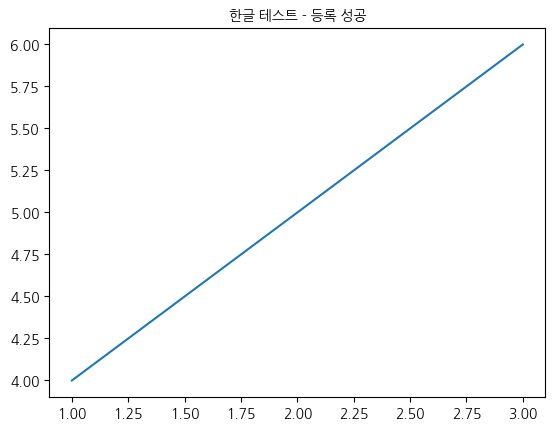

In [15]:
# 테스트
plt.title("한글 테스트 - 등록 성공", fontproperties=font_prop)
plt.plot([1, 2, 3], [4, 5, 6])
plt.show()

In [99]:
import pandas as pd
import numpy as np
import seaborn as sns

In [72]:
train_df = pd.read_csv("./data/mission15_train.csv")
test_df = pd.read_csv("./data/mission15_test.csv")

In [73]:
# 중복값 검사

train_duplicated_count = train_df.duplicated().sum()
test_duplicated_count = test_df.duplicated().sum()
print(f"train 중복값 {train_duplicated_count}개 , test 중복값 {test_duplicated_count}개")

train 중복값 64개 , test 중복값 75개


In [74]:
# 중복값 제거

train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

In [49]:
train_df.describe(include = 'all')

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,6936.000000,6936.000000,6936,6936.000000,6936.000000,6936.000000
unique,NaN,NaN,2,NaN,NaN,NaN
top,NaN,NaN,No,NaN,NaN,NaN
freq,NaN,NaN,3490,NaN,NaN,NaN
mean,4.945646,69.439014,NaN,6.533160,4.610582,55.091407
std,2.592388,17.265709,NaN,1.698652,2.862662,19.142497
min,1.000000,40.000000,NaN,4.000000,0.000000,10.000000
25%,3.000000,54.000000,NaN,5.000000,2.000000,40.000000
50%,5.000000,69.000000,NaN,7.000000,5.000000,55.000000
75%,7.000000,85.000000,NaN,8.000000,7.000000,70.000000


In [50]:
test_df.describe(include = 'all')

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
count,2925.000000,2925.000000,2925,2925.000000,2925.000000
unique,NaN,NaN,2,NaN,NaN
top,NaN,NaN,No,NaN,NaN
freq,NaN,NaN,1501,NaN,NaN
mean,5.093675,69.432137,NaN,6.533333,4.527179
std,2.581525,17.457000,NaN,1.695129,2.874310
min,1.000000,40.000000,NaN,4.000000,0.000000
25%,3.000000,54.000000,NaN,5.000000,2.000000
50%,5.000000,69.000000,NaN,7.000000,5.000000
75%,7.000000,85.000000,NaN,8.000000,7.000000


In [55]:
## Nan값 검사

train_df.isna().sum() 

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

In [56]:
test_df.isna().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
dtype: int64

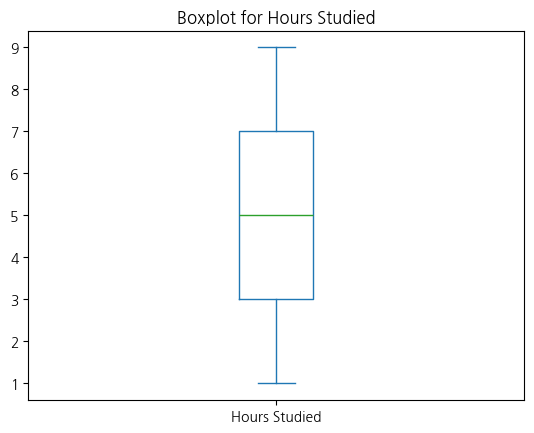

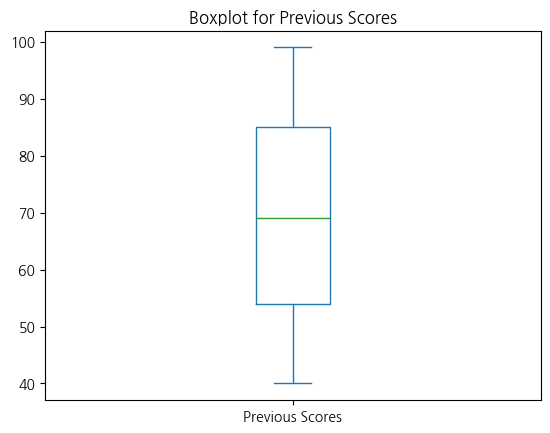

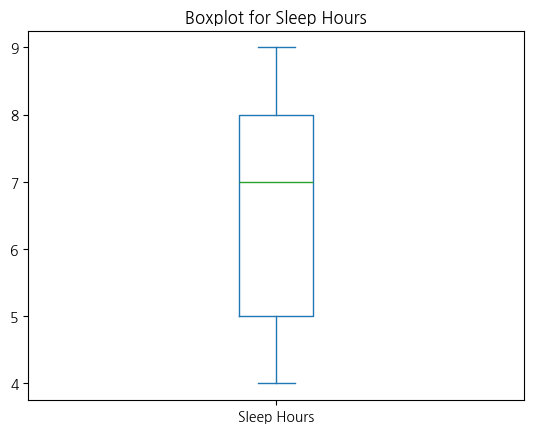

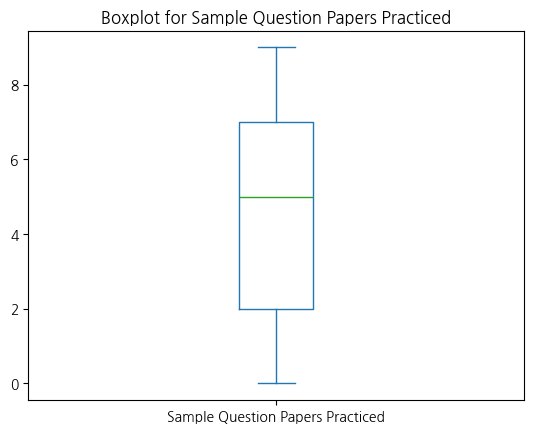

In [63]:
## 컬럼별 이상치 검사

def anomaly_distribution(df, columns): # 이상치 확인
    """
    주어진 DataFrame에서 지정된 열에 대해 박스플롯 생성
    """
    try:
        if isinstance(columns, list):
            for col in columns:
                plt.figure()
                df[col].plot.box()
                plt.title(f'Boxplot for {col}')
                plt.show()
        else:
            plt.figure()
            df[columns].plot.box()
            plt.title(f'Boxplot for {columns}')
            plt.show()
    except KeyError as e:
        print(f"Error: {e} - Ensure the column exists in the DataFrame.")
    except Exception as e:
        print(f"Unexpected error: {e}")
        

# 다중 열 박스플롯
anomaly_distribution(train_df, ['Hours Studied', 'Previous Scores','Sleep Hours','Sample Question Papers Practiced'])         


In [68]:
## Extracurricular Activities 컬럼 

train_df['Extracurricular Activities'].value_counts()

Extracurricular Activities
No     3490
Yes    3446
Name: count, dtype: int64

-> Yes / No 를 1 , 0 으로 변경해서 모델이 학습할수있는 숫자 형태로 변경

In [85]:
for df in [train_df, test_df]:
    df['Extracurricular Activities'] = df['Extracurricular Activities'].eq("Yes").astype("Int8")

In [86]:
train_df['Extracurricular Activities'].value_counts()

Extracurricular Activities
0    3490
1    3446
Name: count, dtype: Int64

In [95]:
## heatmap

columns = ['Hours Studied','Previous Scores','Extracurricular Activities','Sleep Hours','Sample Question Papers Practiced','Performance Index']

correlation = train_df[columns].corr()

pi_corr = correlation['Performance Index'].sort_values(ascending=False)
print(pi_corr)

Performance Index                   1.000000
Previous Scores                     0.913634
Hours Studied                       0.376107
Sample Question Papers Practiced    0.049628
Sleep Hours                         0.049623
Extracurricular Activities          0.026183
Name: Performance Index, dtype: float64


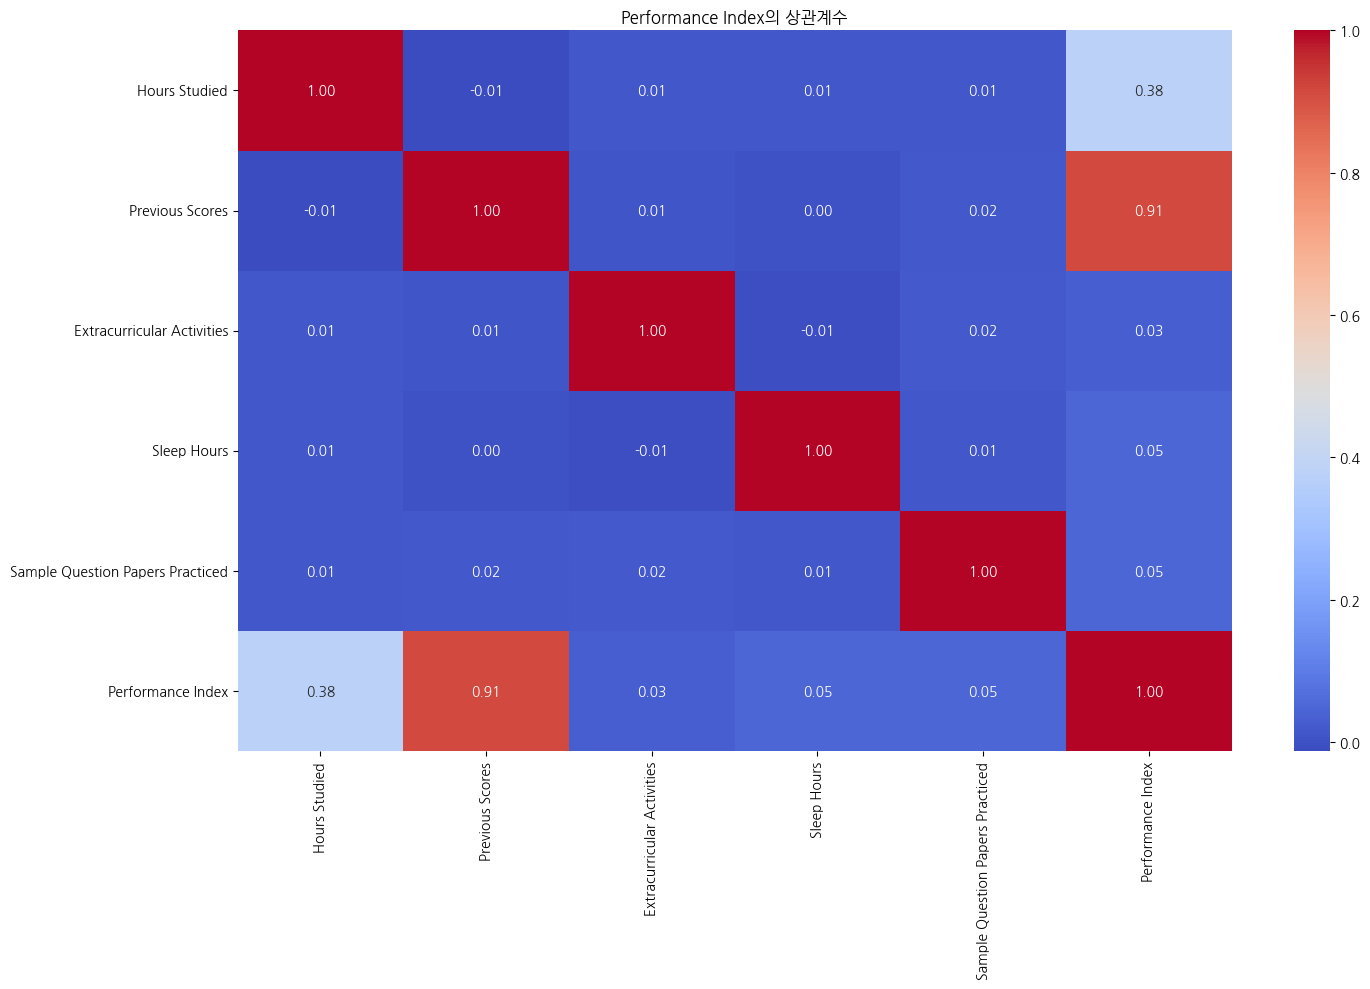

In [101]:
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Performance Index의 상관계수")
plt.tight_layout()
plt.show()

## 회귀 모델링

In [150]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor
import joblib
np.random.seed(42)

In [199]:
# 컬럼 정의

FEATURES = [
    'Hours Studied',
    'Previous Scores',
    'Extracurricular Activities', 
    'Sleep Hours',
    'Sample Question Papers Practiced'
]

TARGET = 'Performance Index'

In [200]:
X = train_df[FEATURES].values
y = train_df[TARGET].values

In [201]:
X,y

(array([[6, 73, 0, 7, 2],
        [1, 89, 1, 7, 2],
        [3, 97, 1, 8, 0],
        ...,
        [6, 57, 1, 7, 3],
        [8, 80, 0, 7, 9],
        [9, 87, 1, 7, 6]], dtype=object),
 array([58., 64., 75., ..., 43., 73., 84.]))

In [202]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [203]:
print(len(X_train))
print(len(X_valid))
print(len(y_train))
print(len(y_valid))

5548
1388
5548
1388


In [211]:
pipe = Pipeline([('scaler', StandardScaler()), ('model',Ridge())])

In [212]:
param_grid = {
    'model__alpha' : [0.01, 0.1, 1.0, 3.0, 10.0, 30.0, 100.0]
}

In [213]:
gs = GridSearchCV(
    pipe, param_grid=param_grid,scoring = 'neg_root_mean_squared_error', cv=5, n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

,estimator,"Pipeline(step...l', Ridge())])"
,param_grid,"{'model__alpha': [0.01, 0.1, ...]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [214]:
best_model = gs.best_estimator_

In [215]:
# 검증 성능(RMSE)
y_pred = best_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f"[Holdout RMSE] {rmse:.4f}")
print(f"[Best alpha]  {gs.best_params_['model__alpha']}")
cv_best_rmse = np.sqrt(-gs.best_score_)
print(f"[CV best RMSE] {cv_best_rmse:.4f}")

# 7) 최종 모델 저장
joblib.dump(best_model, "model.pkl")
print("Saved: model.pkl")

[Holdout RMSE] 2.0375
[Best alpha]  0.1
[CV best RMSE] 1.4312
Saved: model.pkl
